In [8]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot'), os.path.join(home, 'astrobot', 'tests')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot import pmf

import numpy as np 
import pandas as pd
from pprint import pprint 
import matplotlib.pyplot as plt 
from functools import reduce 
def pp(x, *args): pprint(x) if not args else (pprint(x), pp(*args))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# bldg_stock namespace
def get_osm_url(bldg_id, zero_pad=7):
    zeros = reduce(
        lambda a, b: str(a)+"0", range(zero_pad - int(np.log10(bldg_id) + 1)))
    return ("https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/" +  "end-use-load-profiles-for-us-building-stock/2021/" +
            "comstock_tmy3_release_1/building_energy_models/" + 
            "bldg{}-up00.osm.gz".format(zeros + str(bldg_id)))
            
DATADIR = "C:/users/admin/master/astrobot/resources/rescomstock/resstock"
assert os.path.isdir(DATADIR)
metacom_fpath = os.path.join(DATADIR, "metadata_resstock.tsv")
_comdf = pd.read_csv(metacom_fpath, sep='\t')
_comdf = _comdf.dropna(axis=0, how="any")
_comdf.head(2)

,bldg_id,in.county,in.puma,in.ashrae_iecc_climate_zone_2004,in.building_america_climate_zone,in.iso_rto_region,applicability,weight,in.sqft,in.ahs_region,...,out.propane.total.energy_consumption,out.propane.total.energy_consumption_intensity,out.wood.total.energy_consumption,out.wood.total.energy_consumption_intensity,out.wood.heating.energy_consumption,out.wood.heating.energy_consumption_intensity,out.site_energy.total.energy_consumption,out.site_energy.total.energy_consumption_intensity,upgrade,metadata_index
0,1,G5100230,G51051045,4A,Mixed-Humid,PJM,True,242.131013,1623.0,Non-CBSA South Atlantic,...,0.0,0.0,0.0,0.0,0.0,0.0,39404.872841,24.279034,0,0
1,2,G5600250,G56000400,6B,Cold,None,True,242.131013,617.0,Non-CBSA Mountain,...,0.0,0.0,0.0,0.0,0.0,0.0,26635.835447,43.169912,0,1


In [10]:
def search_comdf_var(var):
    return [col for col in _comdf.columns if var.lower() in col.lower()]

search_comdf_var("in.")
#set(_comdf["in.building_type"])
#_comdf[["metadata_index", "bldg_id"]]
lbl_cz = 'in.ashrae_iecc_climate_zone_2004'
lbl_mf = 'in.geometry_building_type_recs'
_comdf[[lbl_cz, lbl_mf]].head()

,in.ashrae_iecc_climate_zone_2004,in.geometry_building_type_recs
0,4A,Multi-Family with 5+ Units
1,6B,Multi-Family with 2 - 4 Units
2,3A,Multi-Family with 5+ Units
3,2A,Multi-Family with 2 - 4 Units
4,4A,Single-Family Attached


In [11]:
comdf = _comdf.copy()
# pp([c for c in _comdf.columns if "in." in c])

y_lbls = ["eui"] 
X_lbls = ["cz_cat", "cz", "btype_cat", "btype", "weight", "metadata_index", "bldg_id"] 
comdf[["cz_cat", "btype_cat"]] = comdf[["in.ashrae_iecc_climate_zone_2004", "in.geometry_building_type_recs"]]
_kwh_arr, _sqft_arr = comdf["out.site_energy.total.energy_consumption"], comdf["in.sqft"]
comdf[y_lbls[0]] = _kwh_arr / (_sqft_arr / 10.764)  # Convert kWh, ft2 -> kWh/m2

# Integer encoding for cz categories
cz_dict = {cz:i for i, cz in enumerate(np.unique(comdf["cz_cat"]))}
comdf["cz"] = [cz_dict[cz] for cz in comdf["cz_cat"]]
 
# Integer encoding for btype
btype_dict = {bt:i for i, bt in enumerate(np.unique(comdf["btype_cat"]))}
comdf["btype"] = [btype_dict[bt] for bt in comdf["btype_cat"]]

comdf = comdf[X_lbls + y_lbls]
comdf.head(5)


,cz_cat,cz,btype_cat,btype,weight,metadata_index,bldg_id,eui
0,4A,6,Multi-Family with 5+ Units,2,242.131013,0,1,261.339526
1,6B,12,Multi-Family with 2 - 4 Units,1,242.131013,1,2,464.680928
2,3A,3,Multi-Family with 5+ Units,2,242.131013,2,3,309.696571
3,2A,1,Multi-Family with 2 - 4 Units,1,242.131013,3,4,140.524085
4,4A,6,Single-Family Attached,3,242.131013,4,5,62.699874


In [12]:
# print(_comdf.shape)
# print(_comdf.weight.sum())

# from tests.pmf_test import test_make_pmf, test_make_bin_idx, test_make_bin_edges
# from tests.pmf_test import test_make_joint_pmf 

# from scipy.stats._binned_statistic import binned_statistic
# pd.set_option("display.precision", 6)

# test_make_bin_edges()
# test_make_bin_idx()
# test_make_pmf()

# test_make_joint_pmf()


In [51]:
np.warnings.filterwarnings('ignore')
data = comdf.query(
    '"Multi-Family with 5+ Units" in btype_cat & cz > 8')
data.loc[:, "idx"] = np.arange(data.shape[0])
data.set_index("idx")

# Plot the empirical distribution of marginal EUI: sum_ij{ P(eui, btype_i, cz_j) }
bins=50
eui = pmf.Pmf(data.eui, bins, data.weight, id=data.index)




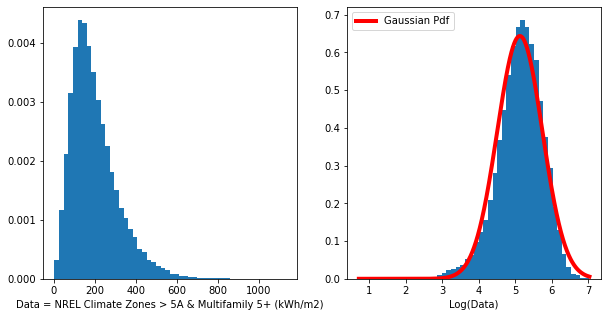

In [64]:
from scipy.stats import norm 
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(data.eui, weights=data.weight, bins=50, density=True);
ax[0].set_xlabel("Data = NREL Climate Zones > 5A & Multifamily 5+ (kWh/m2)")
log_data = np.sort(np.log(data.eui))
ax[1].hist(log_data, weights=data.weight, bins=50, density=True);
n = norm.pdf(log_data, loc=np.mean(log_data), scale=np.std(log_data))
ax[1].plot(log_data, n, c='r', linewidth=4, label="Gaussian Pdf")
ax[1].set_xlabel("Log(Data)")
ax[1].legend()

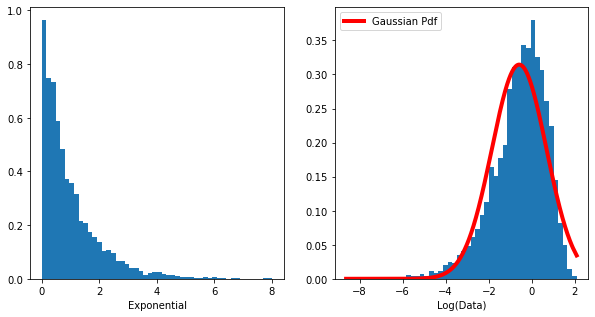

In [66]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
exp_data = np.random.exponential(size=5000)
ax[0].hist(exp_data, bins=50, density=True);
ax[0].set_xlabel("Exponential")
ax[1].hist(np.log(exp_data), bins=50, density=True);
ax[1].set_xlabel("Log(Exponential)")
log_data = np.sort(np.log(exp_data))
n = norm.pdf(log_data, loc=np.mean(log_data), scale=np.std(log_data))
ax[1].plot(log_data, n, c='r', linewidth=4, label="Gaussian Pdf")
ax[1].set_xlabel("Log(Data)")
ax[1].legend()
